In [1]:
import csv
from movies.constants import SEED
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
albums = pd.read_csv('albums_embeddings_node2vec_BFS_10_80.csv', index_col='id', quoting=csv.QUOTE_ALL)
albums.embedding = albums.embedding.apply(lambda embedding: eval(embedding))

# Visualization

In [3]:
pca = PCA(n_components=2, random_state=SEED)
principal_components = pca.fit_transform(np.array(albums.embedding.tolist()))

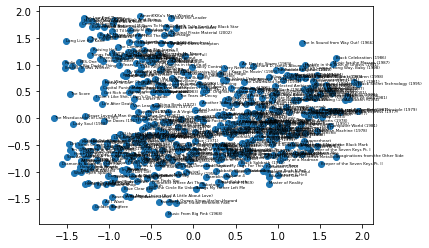

In [4]:
plt.scatter(principal_components[:, 0], principal_components[:, 1])

for index, row in albums.iterrows():
    plt.annotate(row.title, (principal_components[index, 0], principal_components[index, 1]), fontsize=4)

plt.show()

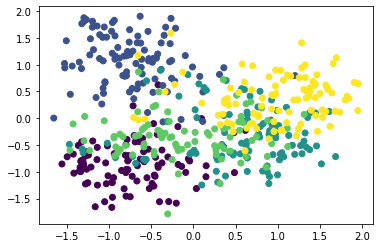

In [5]:
albums_labels = {label:index for index, label in enumerate(albums.label.unique())}
albums_colours = albums.label.map(albums_labels)

plt.scatter(principal_components[:, 0], principal_components[:, 1], c=albums_colours)
plt.show()

# Similarity

In [6]:
cos_similarity = cosine_similarity(np.array(albums.embedding.tolist()), np.array(albums.embedding.tolist()))

In [7]:
albums_index = 312
print(albums.iloc[albums_index].title)

closest_albums = cos_similarity[albums_index].argsort()[-6:][::-1]
for closest_album in closest_albums[1:]:
    print(albums.iloc[closest_album].title, cos_similarity[albums_index, closest_album])

A Hard Day's Night (1964)
Very (1993) 0.7830144015902561
Sgt. Pepper's Lonely Hearts Club Band (1967) 0.7828194117982017
Behaviour (1990) 0.7719751813574999
Rubber Soul (1965) 0.737230442378239
Actually (1987) 0.7370749048701638


# Classification

In [8]:
X_train, X_test, y_train, y_test = train_test_split(np.array(albums.embedding.tolist()), albums_colours.to_numpy(), train_size=0.75, random_state=SEED)
logistic_classifier = LogisticRegressionCV(cv=10, scoring='accuracy', multi_class='ovr', max_iter=300, random_state=SEED)
logistic_classifier.fit(X_train, y_train)

LogisticRegressionCV(cv=10, max_iter=300, multi_class='ovr', random_state=17,
                     scoring='accuracy')

In [9]:
y_pred = logistic_classifier.predict(X_test)
print(classification_report(y_test, y_pred, target_names=albums.label.unique()))

              precision    recall  f1-score   support

     country       0.84      0.89      0.86        18
         rap       0.94      0.91      0.92        32
       metal       0.84      0.95      0.89        22
        rock       0.74      0.64      0.68        22
  electronic       0.81      0.81      0.81        26

    accuracy                           0.84       120
   macro avg       0.83      0.84      0.83       120
weighted avg       0.84      0.84      0.84       120

